# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [5]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from collections import Counter
from operator import itemgetter

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 0.1: Loading Data

In [5]:
# load in the azdias dataset 
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv',sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
#shape of the dataframe
azdias.shape

(891221, 366)

In [8]:
#content of the file
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3



### The column headers are not self-explainatory. 


In order to learn more about the columns depicted in the files, we refer to two Excel spreadsheets provided in the workspace. 
- [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. 
- [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

## Part 0.2: Features Explained

In order to know what the corresponding features are.
We leverage the dictionary provided by the DIAS Attribute -Values 2017 file.
- Analyze the feature informaiton by assessing its shape, and content
- Again, delete the bad quality featues "NaN" / extract non-"NaN" info
- Convert the values to a list for repeated attributes
- Save the clean features in a new file for later references

In [6]:
# Load in the feature information
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
#feat_info.to_excel('feat_info.xlsx')
feat_info.head(15)

In [28]:
#shape of total feature information
feat_info.shape

(2258, 4)

In [29]:
#discover a number of "NaN"s
#clean up the file by extracting non-NaN row-values

feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute

feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
feat_info.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [31]:
#note there're only 302 valid features 
feat_info.shape 

(302, 4)

In [35]:
#convert the values into list items
#we need to use this to clean up the datasets

unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
unknowns.head(15)

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


## Part 0.3: Cleaning up the data using Feature Info


Now that we have built a filter with valid features for the dataset, we look at the low quality features columns & rows and delete them
- First, we re-model the dataset with valid features from *unkowns*
- Then, we convert the negative and invalid values to "NaN"
- Based on the visualization of the "NaN" distribution, we define "low quality" data by a treshold number of "NaN"
    - by columns
    - by rows
    - by catagrogies 
- Clean up unnecessary features (columns) and entries (rows)

In [37]:
#identify missing or unknowns and drop them or convert those value to NaN

start = time.time()
    
for row in unknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

azdias.head()


AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [38]:
#data imputation completed as you can see the negative vaules are replaced by NaN

azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


### Assessing the missing data in columns
Sort the Attributes by the number of "NaN" Values

In [42]:
#performing the accessment of missing values for each column in the dataset
col_nan = azdias.shape[0] - azdias.count()
col_nan.sort_values()

LNR                                 0
D19_WEIN_FEINKOST                   0
D19_VOLLSORTIMENT                   0
D19_VERSICHERUNGEN                  0
D19_VERSI_ONLINE_DATUM              0
D19_VERSI_OFFLINE_DATUM             0
D19_VERSI_DATUM                     0
D19_VERSAND_REST                    0
D19_TIERARTIKEL                     0
D19_TELKO_REST                      0
D19_TELKO_MOBILE                    0
D19_TECHNIK                         0
D19_SONSTIGE                        0
D19_SCHUHE                          0
D19_SAMMELARTIKEL                   0
D19_REISEN                          0
D19_RATGEBER                        0
D19_NAHRUNGSERGAENZUNG              0
D19_LEBENSMITTEL                    0
D19_KOSMETIK                        0
D19_KONSUMTYP_MAX                   0
D19_KINDERARTIKEL                   0
FINANZ_ANLEGER                      0
FINANZ_HAUSBAUER                    0
FINANZ_MINIMALIST                   0
FINANZ_SPARER                       0
ZABEOTYP    

### Visualization of NaN Distribution

Text(0.5,1,'Distribution of missing value counts per column')

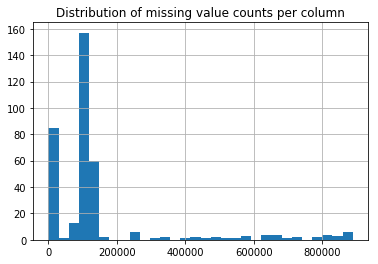

In [44]:
#take a look at the distributions of the missing data by column
col_nan.hist(bins=30)
plt.title('Distribution of missing value counts per column')

**Based on the bar chart, we decide to filter out the features with more than 200k missing values**


- remaining fearues still includes majority of the data

In [50]:
# Remove columns which have > 200000 missing values
cols_to_drop = azdias.columns[col_nan > 200000]
print(cols_to_drop)
azdias.drop(cols_to_drop, axis=1, inplace = True)
azdias.shape

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LOTTO',
       'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUM

(891221, 318)

In [51]:
#now we examine the rows and clean up
row_na = azdias.shape[1] - azdias.count(axis = 1)
row_na.head()

0    232
1      0
2      0
3      4
4      0
dtype: int64

### Assessing the invalid data for rows

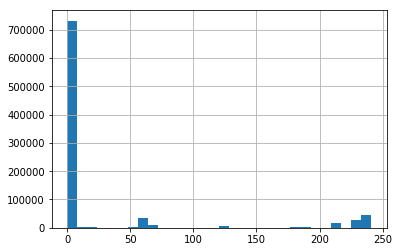

In [52]:
#check the rough threshold of the missing value of the data (~10)
row_na.hist(bins=30);

In [53]:
# Remove rows which contain more than 10 missing values per row
rows_to_drop = azdias.index[row_na > 10]
azdias.drop(rows_to_drop, axis=0, inplace = True)
azdias.shape

(732489, 318)

### Now that we've shrank the size of the dataframe by ~18%, we are going to scrutinize more on the category and type of informaiton 

In [57]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [58]:
# The only binary categorical variable that does not take 
# integer values is OST_WEST_KZ which uses either W or O
# will be re-encoded with 1 and 0.  Other binary categorical
# variables will be lest as is. 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [59]:
# If column has less than 10 levels, re-encode using dummy variables.
# If column has equal to or more than 10 different values, drop for
# simplicity. Make lists of these columns to be used below.

cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [60]:
# Drop categorical columns with 10 or more values
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(732489, 311)

In [61]:
# Create dummy variables for columns with less than 10 
# unique values then drop the original columns
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)
azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)
azdias.shape

(732489, 361)

In [62]:
# View first few lines of the altered dataset (including the dummary variables at
# the end of the dataframe)
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0,1,0,0,0,0,0,1,0,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0,1,0,0,0,0,1,0,1,0
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0,1,0,0,0,1,0,0,1,0
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0,1,0,0,0,0,1,0,0,1
5,910244,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0,1,0,0,1,0,0,0,0,1


## Part 0.4: Clean_data Function


The azdias data restructuring has completed and now we build a re-usable function to clean any data for comparison
- building a function for data cleaning will boost efficiency for the next customer dataframe
- this function can be used on any new dataframe

In [106]:
def clean_data(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df1: Customer demographics DataFrame
        df2: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df1.columns:
        if df1[col].dtype == np.int64:
            df1[col] = df1[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in df2['attribute']:
        if row in df1.columns:
            na_map = df2.loc[df2['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # remove selected columns, ...
    # These columns were the ones above that had
    # > 200000 missing values in the azdias dataframe
    cols_to_drop = ['EINGEFUEGT_AM','CAMEO_DEUG_2015','CAMEO_INTL_2015', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # remove selected rows, ...
    # These are rows which have >25 missing values
    row_na = df1.shape[1] - df1.count(axis = 1)
    rows_to_drop = df1.index[row_na > 10]
    df1.drop(rows_to_drop, axis=0, inplace = True)
    
    # select, re-encode, and engineer column values
    df1['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df1[col], prefix = col)
        df1 = pd.concat([df1, dummy], axis = 1)
        
    df1.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # Return the cleaned dataframe.
    return df1

## Part 0.5: Customers Data Cleaning
We load the **clean_data** function developed above to clean the customer data
- Note the Customers Data and Azdias differ by three columns 
    - customer_group
    - online_purchase
    - product_group

### Loading the data

In [65]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv',sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
customers.shape

(191652, 369)

In [67]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


### Investigate the 3 extra columns
For the convenience of data analysis, we will store the 3 extra columns into column_extra and drop them from the customer data file

In [68]:
#CUSTOMER_GROUP column
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [69]:
#ONLINE_PURCHASE column
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [70]:

#PRODUCT_GROUP column
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

### Clean up the customer data using clean_data function

In [71]:
# Run the clean_data function on the azdias dataset
customers = clean_data(customers, unknowns)

In [72]:
azdias.columns[~azdias.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [73]:
column_index = azdias.columns.get_loc("GEBAEUDETYP_5.0")
column_index
customers.insert(loc=column_index, column='GEBAEUDETYP_5.0', value=0)
customers.shape[1] == azdias.shape[1] + 3

False

In [87]:
#I've missed this EINGEFUEGT_AM column in the funciton but fixed above
customers = customers.drop(['EINGEFUEGT_AM'], axis=1)
customers.columns[~customers.columns.isin(azdias.columns)]

Index(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype='object')

In [88]:
customers.shape[1] == azdias.shape[1] + 3

True

After making sure the customer data has the same structure as the asdiaz with 3 extra columns, we delete extra columns

In [89]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias, open("azdias_clean.pickle", "wb"))

# Dump the customers dataframe to a pickle object to use for later.
pickle.dump(customers, open("customers_clean.pickle", "wb"))

In [3]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_clean = pickle.load(open("azdias_clean.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_clean = pickle.load(open("customers_clean.pickle", "rb"))

In [4]:
customers_extra_cols = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_extra_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
3,COSMETIC,MULTI_BUYER,0.0
4,FOOD,MULTI_BUYER,0.0
5,COSMETIC_AND_FOOD,MULTI_BUYER,0.0


In [4]:
del customers_clean['PRODUCT_GROUP']
del customers_clean['CUSTOMER_GROUP']
del customers_clean['ONLINE_PURCHASE']

In [5]:
customers_clean.columns[~customers_clean.columns.isin(azdias_clean.columns)]

Index([], dtype='object')

## Part 0.6: Imputation 
Impute the missing values to the mean of the total using Imputer package

In [6]:
#customers_clean.columns[~customers_clean.columns.isin(azdias_clean.columns)]
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(imputer.transform(customers_clean), columns = customers_clean.columns)

## Part 0.7: Apply featurer scaling

In [7]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_clean = pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(scaler.transform(customers_clean), columns = customers_clean.columns)

In [8]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias_clean, open("azdias_clean.pickle", "wb"))

In [5]:
pickle.dump(customers_extra_cols,open("con_extra.pickle","wb"))
pickle.dump(customers_clean,open("customers_final.pickle","wb"))

In [6]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_final = pickle.load(open("azdias_clean.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_final = pickle.load(open("customers_final.pickle", "rb"))

In [7]:
#Making sure that the features are all correctly scaled
azdias_final.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1.057832,1.259540,0.186291,-0.125909,-0.298802,0.225900,0.334761,-0.060501,-0.179709,0.850294,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,-0.658768,-0.601389,1.891908,-0.907919,0.995188
1,1.057852,1.259540,0.120134,-0.125909,-0.298802,-0.633544,-0.032342,-0.060501,-0.179709,-0.980004,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,-0.658768,1.662818,-0.528567,1.101419,-1.004835
2,1.057855,-0.936066,-0.475280,-0.125909,-0.298802,-1.492988,-0.399445,-0.060501,-1.185501,-0.064855,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,1.517985,-0.601389,-0.528567,1.101419,-1.004835
3,1.057914,-0.936066,-0.342966,-0.125909,-0.298802,1.944788,-0.326025,-0.060501,0.826083,-0.980004,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,-0.658768,1.662818,-0.528567,-0.907919,0.995188
4,1.057925,-0.936066,-0.210651,-0.125909,-0.298802,-0.633544,-0.399445,-0.060501,-1.185501,0.850294,...,-0.408334,0.442039,-0.295954,-0.205922,2.228237,-0.658768,-0.601389,-0.528567,-0.907919,0.995188


In [8]:
customers_final.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-2.436123,-0.936066,-0.475280,-0.125909,-0.298802,0.225900,-0.472866,-0.060501,-2.191293,-0.522430,...,2.448975,0.442039,-0.295954,-0.205922,-0.448785,-0.658768,-0.601389,1.891908,1.101419,-1.004835
1,-1.915300,-0.936066,-0.475280,-0.125909,-0.298802,-0.633544,-0.472866,-0.060501,-0.179709,1.307869,...,2.448975,0.442039,-0.295954,-0.205922,-0.448785,1.517985,-0.601389,-0.528567,-0.907919,0.995188
2,-1.915297,-0.936066,-0.541437,0.000000,-0.298802,-1.492988,-0.472866,-0.060501,-2.191293,1.307869,...,-0.408334,0.442039,-0.295954,-0.205922,2.228237,-0.658768,-0.601389,-0.528567,1.101419,-1.004835
3,-1.915293,-0.936066,-0.078337,-0.125909,-0.298802,1.944788,-0.032342,-0.060501,-0.179709,-0.522430,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,1.517985,-0.601389,-0.528567,-0.907919,0.995188
4,-1.915238,-0.936066,-0.475280,-0.125909,-0.298802,0.225900,-0.472866,-0.060501,-0.179709,1.307869,...,-0.408334,0.442039,-0.295954,-0.205922,-0.448785,1.517985,-0.601389,-0.528567,-0.907919,0.995188


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 1.1: PCA - Principal Component Analysis

### Dimensionality Reduction

We have many components (300 features) and a lot of features are large correlations
- example such as informaiton relating to different car speed ranges (correlations = 1)
- we need to use PCA to minimize the redundency of the features

Principal component analysis is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

Source: [Wikipedia/Principal_Component_Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)

In [16]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [17]:
azdias_pca_all, azdias_X_pca_all = do_pca(None, azdias_final)

### Scree Plot

We plot the scree plot to see the PCA results of explained vairance
- We will find the number of features that matains relatively high explained variance (80%)
- Then we run PCA again to get the final Principal Componants

In [18]:
def scree_plot(pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.1, vals[i]), fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


We run the first scree plot with all the features

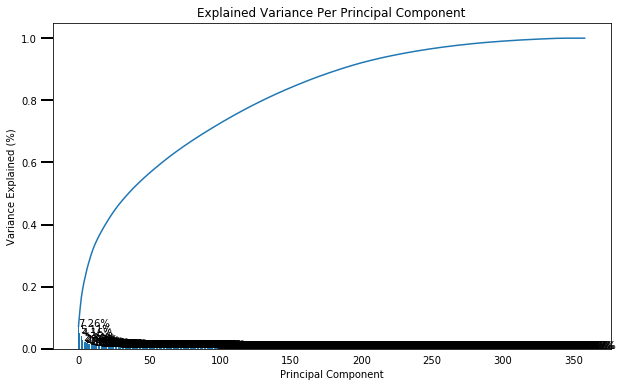

In [19]:
scree_plot(azdias_pca_all)

Based on the curve above, we see that 150 features explains around 80% of the variance
- Note all features would explain all the variance
- However, we want to reduce the number of features and retain relatively high variance 
- Here i belive 180 would be a good number (variance between 80-90%)

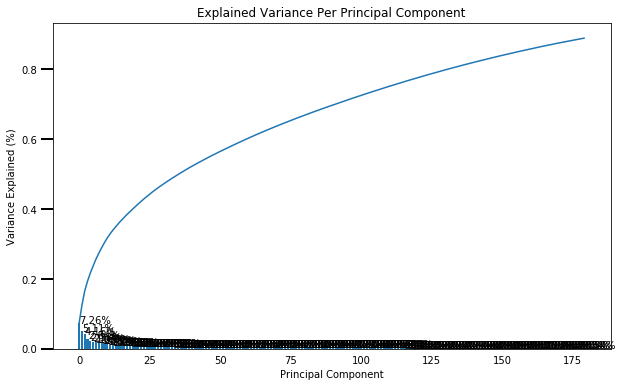

In [20]:
azdias_pca_180, azdias_X_pca_180 = do_pca(180, azdias_final)
scree_plot(azdias_pca_180)

In [26]:
pickle.dump(azdias_pca_180,open("azdias_pca_180.pickle","wb"))
pickle.dump(azdias_X_pca_180,open("azdias_X_pca_180.pickle","wb"))

### Assessing the PCA results:

First, build some utility functions 

1.  pca_results
    - pca results table 
    - Features and variance explained
    - TOP features
    
    
    
2.  print_pcs
    - prints the composition and description of the Principal Components
    
    
    
3.  print_pcs
    - print the weight of each component

In [21]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# The pca_results function was taken from the class notes and altered

def pca_results(full_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results where figure 1 shows all features sorted
    and figure 2 shows the top 10 negative and positive features.
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization for 1st figure (all columns sorted)
    fig1, ax1 = plt.subplots(figsize = (15,8))

    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().plot(ax = ax1, kind = 'bar');
    ax1.set_ylabel("Feature Weights")
    ax1.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=60)
   
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig2, ax2 = plt.subplots(figsize = (15,8))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().iloc[[0, 1, 2,3,4,5,7,8,9,-10,-9,-8,-7-6,-5,-4 -3, -2, -1]].plot(ax = ax2, kind = 'bar');
    ax2.set_ylabel("Feature Weights")
    ax2.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=60)

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [22]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def print_pcs(df, pca, comp, k=5):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    pc = components.iloc[comp-1].sort_values(ascending=False)
    print(f'Weights for PC{comp}')
    print(f'Top {k} weights')
    print(pc.head(k))
    print('\n')
    print(f'Bottom {k} weights')
    print(pc.tail(k))

In [86]:
def comp_weights(pca, dimension_max, dimension_min , num_features, df):
    components = pd.DataFrame( np.round(pca.components_, 4), columns = df.keys())
    components.index = [i for i in range(1, len(pca.components_)+1)]

    weights_pos = components.iloc[dimension_max-1]
    weights_neg = components.iloc[dimension_min-1]
    fig, ax = plt.subplots(figsize = (15, 4), ncols=2, nrows = 1)
    weights_pos.sort_values(ascending=False)[:num_features].plot(kind='bar', ax = ax[0], color = 'green');
    weights_neg.sort_values(ascending=False)[-num_features:].plot(kind='bar', ax = ax[1], color = 'red');
    
    return fig

PCA results varying component number

,Explained Variance,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
Dimension 1,0.0726,-0.0295,0.0616,0.0832,0.0188,-0.0202,-0.0658,0.0819,-0.0029,0.1012,...,-0.0739,-0.0424,0.0318,0.0150,-0.0175,0.0000,0.0245,-0.0205,-0.0194,0.0110
Dimension 2,0.0511,0.0816,0.0129,0.0192,0.0259,-0.0032,-0.0125,0.0181,0.0108,-0.0391,...,0.0359,-0.0186,0.0160,-0.0012,-0.0172,0.0039,-0.0056,0.0100,-0.0198,0.0137
Dimension 3,0.0417,-0.0259,-0.0460,0.0198,0.0176,-0.0737,-0.0468,0.0226,0.0080,0.0428,...,0.0288,0.0573,-0.0433,-0.0418,-0.0209,-0.0165,-0.0252,0.0666,-0.0122,0.0142
Dimension 4,0.0284,-0.0725,-0.1094,0.0104,0.0121,0.0649,0.1464,0.0109,0.0120,0.0856,...,0.0641,0.0308,-0.0162,-0.0010,0.0065,-0.0167,-0.0061,0.0366,0.0058,0.0086
Dimension 5,0.0233,-0.1126,0.0599,0.0094,0.0108,-0.0223,-0.0693,0.0121,-0.0005,0.0561,...,-0.0189,-0.0058,-0.0058,0.0180,-0.0121,0.0239,-0.0153,0.0009,0.0158,-0.0155
Dimension 6,0.0204,-0.0126,-0.0059,-0.0025,0.0014,-0.0273,0.0023,-0.0036,0.0059,-0.0056,...,0.0069,-0.0073,0.0345,-0.0154,0.1374,0.0542,-0.0995,-0.0689,-0.0073,0.0149
Dimension 7,0.0193,-0.0207,-0.0138,0.0277,0.0096,0.0143,0.0202,0.0266,0.0010,-0.0395,...,-0.0399,-0.0119,0.0102,-0.0018,-0.0249,-0.0097,0.0159,0.0109,0.0108,-0.0152
Dimension 8,0.0169,-0.0329,-0.0196,0.0063,0.0121,0.0032,0.0129,0.0055,0.0055,-0.0652,...,-0.0545,0.0206,-0.0183,-0.0070,-0.0113,0.0015,0.0127,-0.0021,0.0128,-0.0103
Dimension 9,0.0155,-0.0736,0.0275,-0.0607,0.0051,-0.0141,-0.0437,-0.0597,0.0101,0.0266,...,0.0363,0.0243,-0.0323,0.0103,-0.0383,0.0286,-0.0133,0.0236,0.0137,-0.0083
Dimension 10,0.0147,0.0468,-0.0053,0.0285,0.0141,-0.0016,-0.0022,0.0280,-0.0013,-0.0070,...,-0.0011,0.0052,-0.0029,-0.0047,0.0185,-0.0102,-0.0035,-0.0014,-0.0061,0.0063


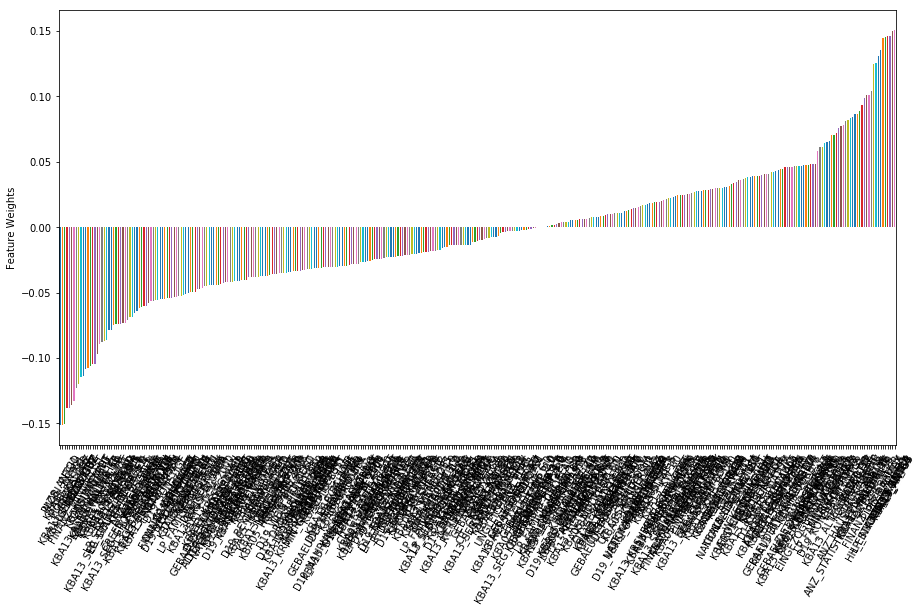

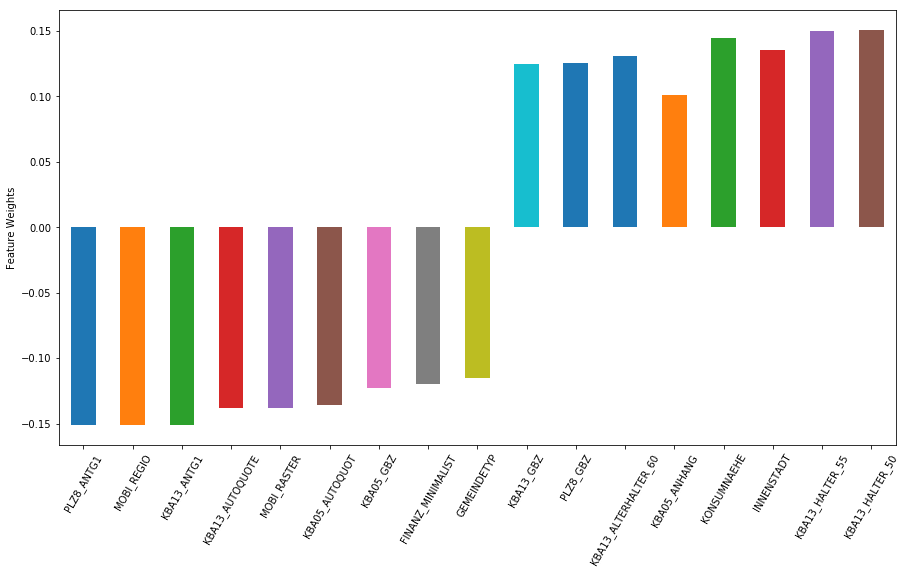

In [27]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_final, azdias_pca_180, component_number = 1)

In [67]:
print_pcs(azdias_final, azdias_pca_180, comp=1)

Weights for PC1
Top 5 weights
PLZ8_ANTG3      0.1507
KBA13_ANTG3     0.1497
KBA13_ANTG4     0.1462
KBA13_BAUMAX    0.1461
PLZ8_ANTG4      0.1450
Name: 0, dtype: float64


Bottom 5 weights
MOBI_RASTER       -0.1379
KBA13_AUTOQUOTE   -0.1379
KBA13_ANTG1       -0.1508
MOBI_REGIO        -0.1509
PLZ8_ANTG1        -0.1515
Name: 0, dtype: float64


,Explained Variance,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
Dimension 1,0.0726,-0.0295,0.0616,0.0832,0.0188,-0.0202,-0.0658,0.0819,-0.0029,0.1012,...,-0.0739,-0.0424,0.0318,0.0150,-0.0175,0.0000,0.0245,-0.0205,-0.0194,0.0110
Dimension 2,0.0511,0.0816,0.0129,0.0192,0.0259,-0.0032,-0.0125,0.0181,0.0108,-0.0391,...,0.0359,-0.0186,0.0160,-0.0012,-0.0172,0.0039,-0.0056,0.0100,-0.0198,0.0137
Dimension 3,0.0417,-0.0259,-0.0460,0.0198,0.0176,-0.0737,-0.0468,0.0226,0.0080,0.0428,...,0.0288,0.0573,-0.0433,-0.0418,-0.0209,-0.0165,-0.0252,0.0666,-0.0122,0.0142
Dimension 4,0.0284,-0.0725,-0.1094,0.0104,0.0121,0.0649,0.1464,0.0109,0.0120,0.0856,...,0.0641,0.0308,-0.0162,-0.0010,0.0065,-0.0167,-0.0061,0.0366,0.0058,0.0086
Dimension 5,0.0233,-0.1126,0.0599,0.0094,0.0108,-0.0223,-0.0693,0.0121,-0.0005,0.0561,...,-0.0189,-0.0058,-0.0058,0.0180,-0.0121,0.0239,-0.0153,0.0009,0.0158,-0.0155
Dimension 6,0.0204,-0.0126,-0.0059,-0.0025,0.0014,-0.0273,0.0023,-0.0036,0.0059,-0.0056,...,0.0069,-0.0073,0.0345,-0.0154,0.1374,0.0542,-0.0995,-0.0689,-0.0073,0.0149
Dimension 7,0.0193,-0.0207,-0.0138,0.0277,0.0096,0.0143,0.0202,0.0266,0.0010,-0.0395,...,-0.0399,-0.0119,0.0102,-0.0018,-0.0249,-0.0097,0.0159,0.0109,0.0108,-0.0152
Dimension 8,0.0169,-0.0329,-0.0196,0.0063,0.0121,0.0032,0.0129,0.0055,0.0055,-0.0652,...,-0.0545,0.0206,-0.0183,-0.0070,-0.0113,0.0015,0.0127,-0.0021,0.0128,-0.0103
Dimension 9,0.0155,-0.0736,0.0275,-0.0607,0.0051,-0.0141,-0.0437,-0.0597,0.0101,0.0266,...,0.0363,0.0243,-0.0323,0.0103,-0.0383,0.0286,-0.0133,0.0236,0.0137,-0.0083
Dimension 10,0.0147,0.0468,-0.0053,0.0285,0.0141,-0.0016,-0.0022,0.0280,-0.0013,-0.0070,...,-0.0011,0.0052,-0.0029,-0.0047,0.0185,-0.0102,-0.0035,-0.0014,-0.0061,0.0063


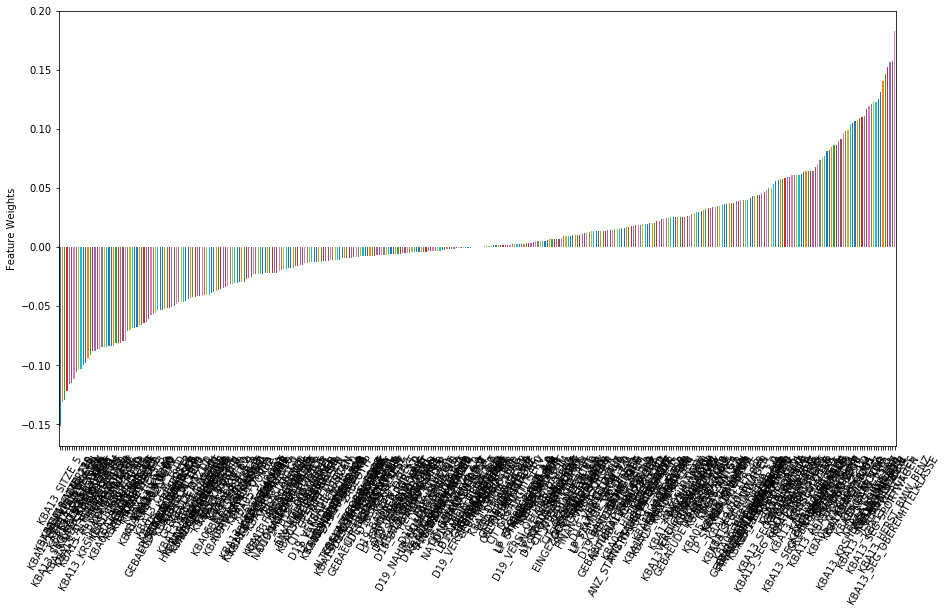

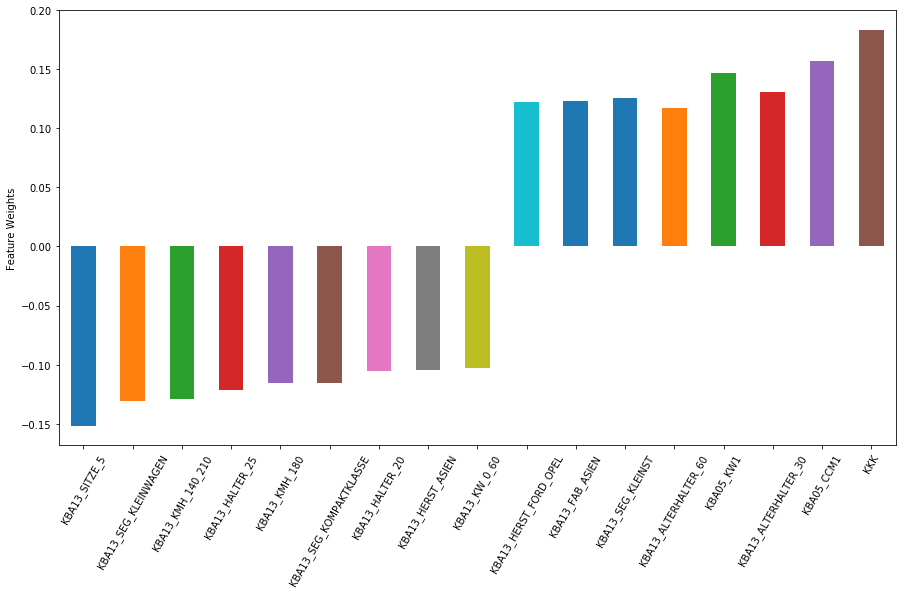

In [28]:
pca_results(azdias_final, azdias_pca_180, component_number = 2)

In [29]:
print_pcs(azdias_final, azdias_pca_180, comp=2)

Weights for PC2
Top 5 weights
KBA13_HERST_BMW_BENZ           0.1831
KBA13_SEG_OBEREMITTELKLASSE    0.1574
KBA13_MERCEDES                 0.1569
KBA13_BMW                      0.1523
KBA13_SITZE_4                  0.1470
Name: 1, dtype: float64


Bottom 5 weights
KBA13_KMH_180          -0.1160
KBA13_HALTER_25        -0.1214
KBA13_KMH_140_210      -0.1292
KBA13_SEG_KLEINWAGEN   -0.1310
KBA13_SITZE_5          -0.1516
Name: 1, dtype: float64


,Explained Variance,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
Dimension 1,0.0726,-0.0295,0.0616,0.0832,0.0188,-0.0202,-0.0658,0.0819,-0.0029,0.1012,...,-0.0739,-0.0424,0.0318,0.0150,-0.0175,0.0000,0.0245,-0.0205,-0.0194,0.0110
Dimension 2,0.0511,0.0816,0.0129,0.0192,0.0259,-0.0032,-0.0125,0.0181,0.0108,-0.0391,...,0.0359,-0.0186,0.0160,-0.0012,-0.0172,0.0039,-0.0056,0.0100,-0.0198,0.0137
Dimension 3,0.0417,-0.0259,-0.0460,0.0198,0.0176,-0.0737,-0.0468,0.0226,0.0080,0.0428,...,0.0288,0.0573,-0.0433,-0.0418,-0.0209,-0.0165,-0.0252,0.0666,-0.0122,0.0142
Dimension 4,0.0284,-0.0725,-0.1094,0.0104,0.0121,0.0649,0.1464,0.0109,0.0120,0.0856,...,0.0641,0.0308,-0.0162,-0.0010,0.0065,-0.0167,-0.0061,0.0366,0.0058,0.0086
Dimension 5,0.0233,-0.1126,0.0599,0.0094,0.0108,-0.0223,-0.0693,0.0121,-0.0005,0.0561,...,-0.0189,-0.0058,-0.0058,0.0180,-0.0121,0.0239,-0.0153,0.0009,0.0158,-0.0155
Dimension 6,0.0204,-0.0126,-0.0059,-0.0025,0.0014,-0.0273,0.0023,-0.0036,0.0059,-0.0056,...,0.0069,-0.0073,0.0345,-0.0154,0.1374,0.0542,-0.0995,-0.0689,-0.0073,0.0149
Dimension 7,0.0193,-0.0207,-0.0138,0.0277,0.0096,0.0143,0.0202,0.0266,0.0010,-0.0395,...,-0.0399,-0.0119,0.0102,-0.0018,-0.0249,-0.0097,0.0159,0.0109,0.0108,-0.0152
Dimension 8,0.0169,-0.0329,-0.0196,0.0063,0.0121,0.0032,0.0129,0.0055,0.0055,-0.0652,...,-0.0545,0.0206,-0.0183,-0.0070,-0.0113,0.0015,0.0127,-0.0021,0.0128,-0.0103
Dimension 9,0.0155,-0.0736,0.0275,-0.0607,0.0051,-0.0141,-0.0437,-0.0597,0.0101,0.0266,...,0.0363,0.0243,-0.0323,0.0103,-0.0383,0.0286,-0.0133,0.0236,0.0137,-0.0083
Dimension 10,0.0147,0.0468,-0.0053,0.0285,0.0141,-0.0016,-0.0022,0.0280,-0.0013,-0.0070,...,-0.0011,0.0052,-0.0029,-0.0047,0.0185,-0.0102,-0.0035,-0.0014,-0.0061,0.0063


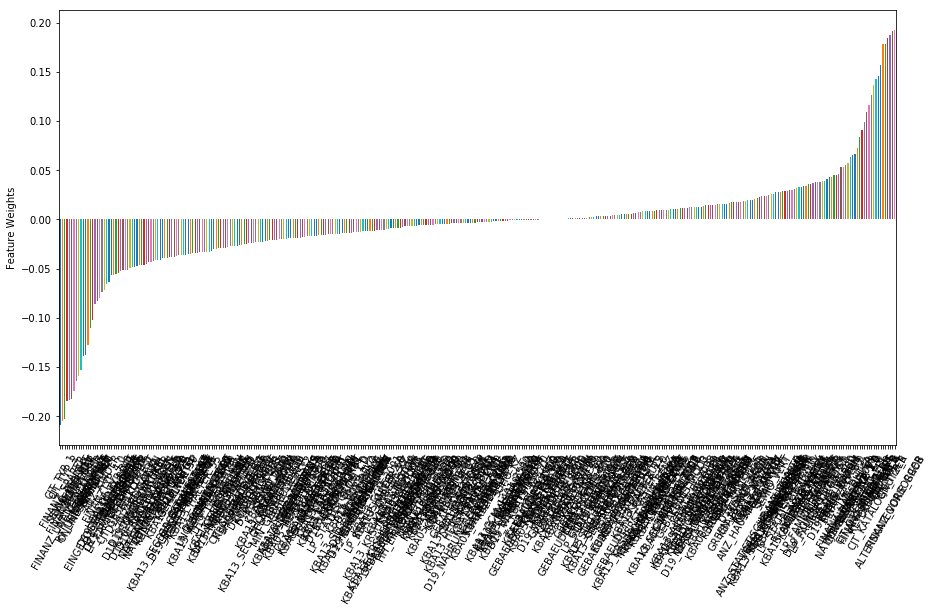

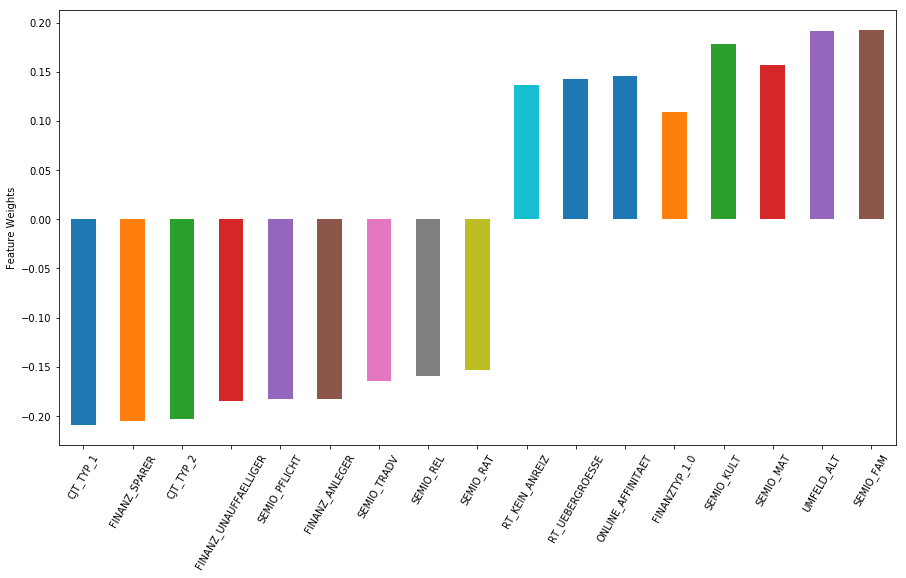

In [30]:
pca_results(azdias_final, azdias_pca_180, component_number = 3)

In [31]:
print_pcs(azdias_final, azdias_pca_180, comp=3)

Weights for PC3
Top 5 weights
FINANZ_VORSORGER        0.1925
CJT_TYP_5               0.1913
ALTERSKATEGORIE_GROB    0.1879
CJT_TYP_4               0.1845
CJT_TYP_6               0.1784
Name: 2, dtype: float64


Bottom 5 weights
SEMIO_PFLICHT           -0.1832
FINANZ_UNAUFFAELLIGER   -0.1843
CJT_TYP_2               -0.2031
FINANZ_SPARER           -0.2049
CJT_TYP_1               -0.2094
Name: 2, dtype: float64


,Explained Variance,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
Dimension 1,0.0726,-0.0295,0.0616,0.0832,0.0188,-0.0202,-0.0658,0.0819,-0.0029,0.1012,...,-0.0739,-0.0424,0.0318,0.0150,-0.0175,0.0000,0.0245,-0.0205,-0.0194,0.0110
Dimension 2,0.0511,0.0816,0.0129,0.0192,0.0259,-0.0032,-0.0125,0.0181,0.0108,-0.0391,...,0.0359,-0.0186,0.0160,-0.0012,-0.0172,0.0039,-0.0056,0.0100,-0.0198,0.0137
Dimension 3,0.0417,-0.0259,-0.0460,0.0198,0.0176,-0.0737,-0.0468,0.0226,0.0080,0.0428,...,0.0288,0.0573,-0.0433,-0.0418,-0.0209,-0.0165,-0.0252,0.0666,-0.0122,0.0142
Dimension 4,0.0284,-0.0725,-0.1094,0.0104,0.0121,0.0649,0.1464,0.0109,0.0120,0.0856,...,0.0641,0.0308,-0.0162,-0.0010,0.0065,-0.0167,-0.0061,0.0366,0.0058,0.0086
Dimension 5,0.0233,-0.1126,0.0599,0.0094,0.0108,-0.0223,-0.0693,0.0121,-0.0005,0.0561,...,-0.0189,-0.0058,-0.0058,0.0180,-0.0121,0.0239,-0.0153,0.0009,0.0158,-0.0155
Dimension 6,0.0204,-0.0126,-0.0059,-0.0025,0.0014,-0.0273,0.0023,-0.0036,0.0059,-0.0056,...,0.0069,-0.0073,0.0345,-0.0154,0.1374,0.0542,-0.0995,-0.0689,-0.0073,0.0149
Dimension 7,0.0193,-0.0207,-0.0138,0.0277,0.0096,0.0143,0.0202,0.0266,0.0010,-0.0395,...,-0.0399,-0.0119,0.0102,-0.0018,-0.0249,-0.0097,0.0159,0.0109,0.0108,-0.0152
Dimension 8,0.0169,-0.0329,-0.0196,0.0063,0.0121,0.0032,0.0129,0.0055,0.0055,-0.0652,...,-0.0545,0.0206,-0.0183,-0.0070,-0.0113,0.0015,0.0127,-0.0021,0.0128,-0.0103
Dimension 9,0.0155,-0.0736,0.0275,-0.0607,0.0051,-0.0141,-0.0437,-0.0597,0.0101,0.0266,...,0.0363,0.0243,-0.0323,0.0103,-0.0383,0.0286,-0.0133,0.0236,0.0137,-0.0083
Dimension 10,0.0147,0.0468,-0.0053,0.0285,0.0141,-0.0016,-0.0022,0.0280,-0.0013,-0.0070,...,-0.0011,0.0052,-0.0029,-0.0047,0.0185,-0.0102,-0.0035,-0.0014,-0.0061,0.0063


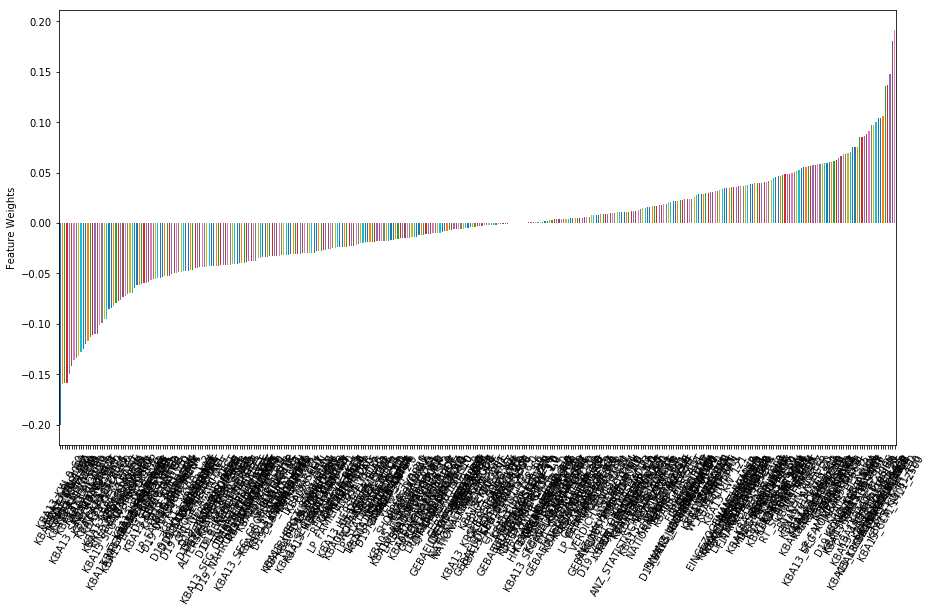

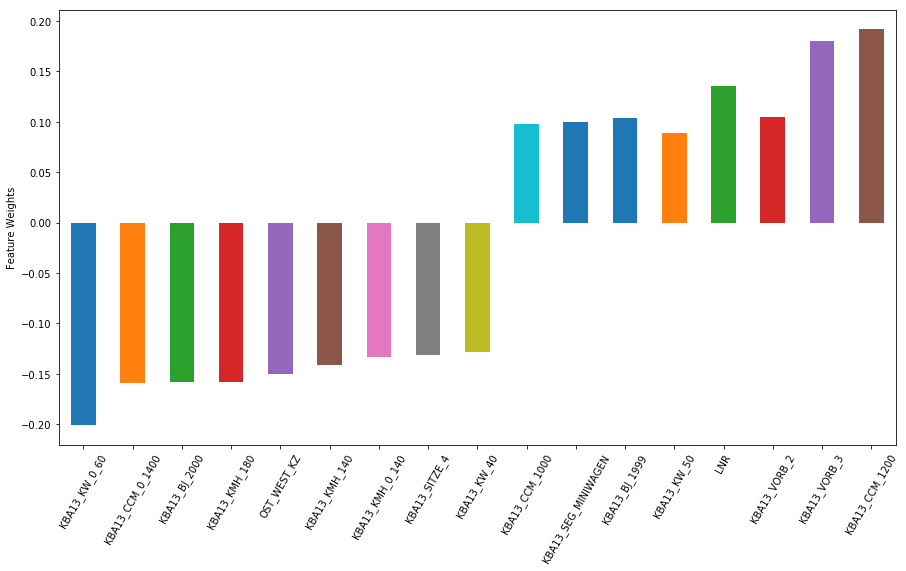

In [32]:
pca_results(azdias_final, azdias_pca_180, component_number = 5)

In [33]:
print_pcs(azdias_final, azdias_pca_180, comp=5)

Weights for PC5
Top 5 weights
KBA13_KW_61_120        0.1913
KBA13_KMH_210          0.1800
KBA13_CCM_1401_2500    0.1479
KBA13_SITZE_5          0.1371
KBA13_VORB_0           0.1357
Name: 4, dtype: float64


Bottom 5 weights
OST_WEST_KZ        -0.1500
KBA13_KMH_180      -0.1581
KBA13_BJ_2000      -0.1583
KBA13_CCM_0_1400   -0.1593
KBA13_KW_0_60      -0.2005
Name: 4, dtype: float64


## Part 1.2: Clustering using k-means

Using the Principal Components from above, we divide the data into different numbers of clusters
- We decide the number of clusters to use by looking at the elbow plot

In [45]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    
    INPUT: 
        data: Demographics DataFrame
        start_K: Inclusive starting value for cluster number
        end_K: Exclusive stopping value for cluster number
        step: Step value between start_K and end_K
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    score_list = []
    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)
        print(score)
    

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

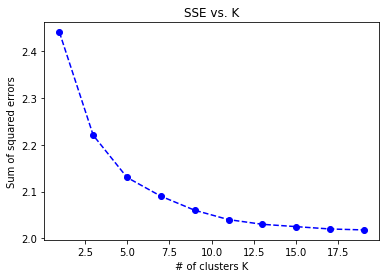

In [46]:
elbow_plot(azdias_X_pca_180, 1, 20, 2)

8 Seems like a kinky point so we use 8 clusters

In [47]:
azdias_kmeans = KMeans(8)
azdias_model = azdias_kmeans.fit(azdias_X_pca_180)
azdias_labels = azdias_model.predict(azdias_X_pca_180)

In [49]:
population_labels = azdias_kmeans.labels_

### Customer Data

In [51]:
customers_pca_180 = azdias_pca_180.transform(customers_final)

In [52]:
customers_labels = azdias_model.predict(customers_pca_180)

In [54]:
counts_customer = Counter(customers_labels)
n_customers = customers_pca_180.shape[0]
customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

In [56]:
counts_population = Counter(population_labels)
n_population = azdias_X_pca_180.shape[0]
population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

In [57]:
# store all the data into different value sets

customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

In [3]:
# printing out all the customer and consumer cluster data (8 each) to compare
all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

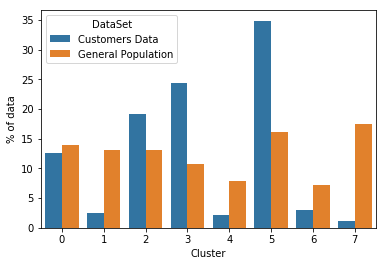

In [70]:
sns.barplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters)
plt.show()

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# General Population data compared to the customer?

over_cluster = 7

print(f'Proportion of general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'Proportion of customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')

Proportion of general population in cluster 7: 17.519717019641252%
Proportion of customer population in cluster 7: 1.2027072345355323%



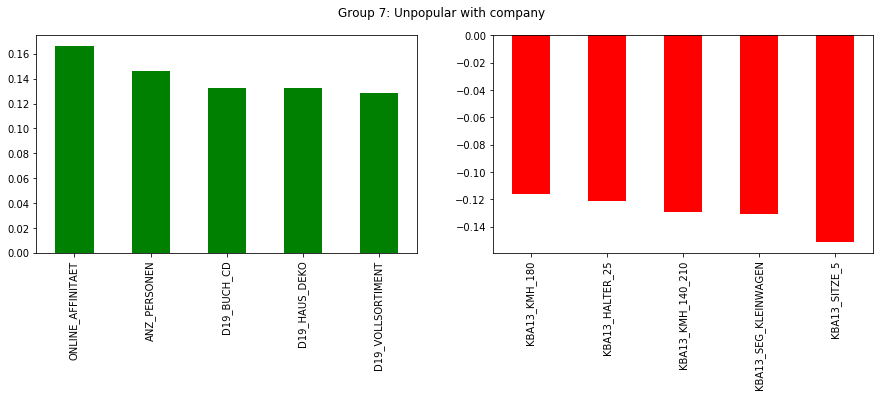

In [100]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series( azdias_kmeans.cluster_centers_[over_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series( azdias_kmeans.cluster_centers_[over_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(azdias_pca_180, pca_feat_max, pca_feat_min, 5, customers_final)
plt.suptitle(f'Group {over_cluster}: Unpopular with company');

In [99]:
pca_inverse = azdias_pca_180.inverse_transform(azdias_kmeans.cluster_centers_[over_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers_final.columns)

unpopular_features = ['ONLINE_AFFINITAET', 'ANZ_PERSONEN', 'D19_BUCH_CD', 'D19_HAUS_DEKO', 'D19_VOLLSORTIMENT']
print('Unpopular with company')
df[unpopular_features]

Unpopular with company


,ONLINE_AFFINITAET,ANZ_PERSONEN,D19_BUCH_CD,D19_HAUS_DEKO,D19_VOLLSORTIMENT
0,0.165164,-0.231124,-0.266716,-0.240229,-0.293801


In [92]:
# What kinds of people are part of a cluster that is underrepresented in the
# General Population data compared to the customer?

under_cluster = 5

print(f'Proportion of general population in cluster {under_cluster}: {population_freqs[under_cluster]}%')
print(f'Proportion of customer population in cluster {under_cluster}: {customer_freqs[under_cluster]}%\n')

Proportion of general population in cluster 5: 16.16365569994908%
Proportion of customer population in cluster 5: 34.89985061431054%



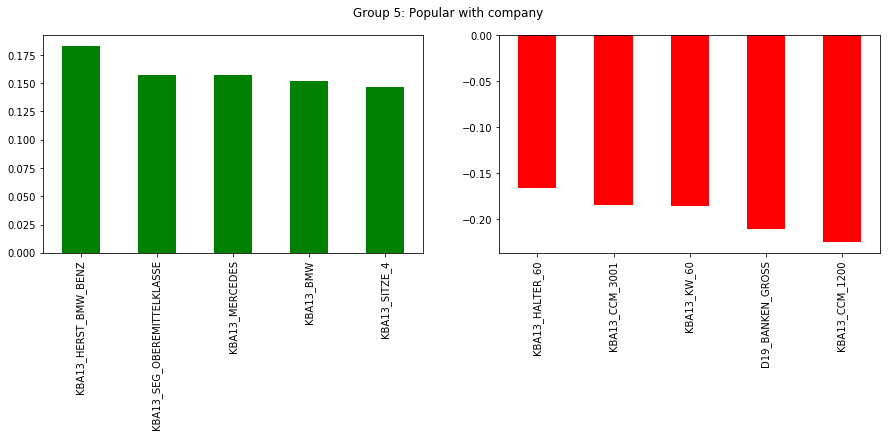

In [94]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series( azdias_kmeans.cluster_centers_[under_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series( azdias_kmeans.cluster_centers_[under_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(azdias_pca_180, pca_feat_max, pca_feat_min, 5, customers_final)
plt.suptitle(f'Group {under_cluster}: Popular with company');

In [101]:
pca_inverse = azdias_pca_180.inverse_transform(azdias_kmeans.cluster_centers_[under_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers_final.columns)

popular_features = ['KBA13_HERST_BMW_BENZ', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_MERCEDES', 'KBA13_BMW', 'KBA13_SITZE_4']

print('Popular with company')
df[popular_features]

Popular with company


,KBA13_HERST_BMW_BENZ,KBA13_SEG_OBEREMITTELKLASSE,KBA13_MERCEDES,KBA13_BMW,KBA13_SITZE_4
0,-0.010415,-0.021174,0.037125,-0.050152,0.028237


## Results - Compare Customer Data to Demographics Data
### Popular with company - Cluster 5


- 'KBA13_HERST_BMW_BENZ', share of BMW & Mercedes Benz within the PLZ8
- 'KBA13_SEG_OBEREMITTELKLASSE', share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
- 'KBA13_MERCEDES', share of MERCEDES within the PLZ8
- 'KBA13_BMW', share of BMW within the PLZ8
- 'KBA13_SITZE_4', number of cars with less than 5 seats in the PLZ8

### Unpopular with company - Cluster 7

- 'ONLINE_AFFINITAET', online affinity
- 'ANZ_PERSONEN', number of adult persons in the household  
- 'D19_BUCH_CD', transactional activity based on the product group BOOKS and CDS
- 'D19_HAUS_DEKO', transactional activity based on the product group HOUSE DECORATION
- 'D19_VOLLSORTIMENT', transactional activity based on the product group COMPLETE MAIL-ORDER OFFERS


**PCA treshold is not too ideal on this project because the KBAs are still too similar, but for this project purpose, we will just use 180 so the variance are more accurately explained**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Load & Clean the training data

In [102]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [104]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
unknowns = pickle.load(open("unknowns.pickle", "rb"))

In [108]:
# Clean the training data (may need to rerun cell with cleaning function, loading unknowns.pickle)
mailout_train = clean_data(mailout_train, unknowns)

In [110]:
mailout_train.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1763.0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,0,1,0,0,0,0,0,1,0,1
1,1771.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0,0,1,0,0,0,1,0,1,0
2,1776.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,...,1,1,0,0,0,0,0,1,1,0
3,1460.0,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,0,1,0,0,0,1,0,0,0,1
4,1783.0,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,0,1,0,0,0,1,0,0,1,0


In [112]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = mailout_train['RESPONSE']
del mailout_train['RESPONSE']
X = mailout_train
y.shape, X.shape

((33266,), (33266, 358))

In [113]:
# Obtain the vale counts for the response column
y.value_counts()

0.0    32854
1.0      412
Name: RESPONSE, dtype: int64

In [114]:
# Print first few responses to ensre they are in an expected form
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: RESPONSE, dtype: float64

In [115]:
# Perform imputation on train df
imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1763.0,1.0,15.0,0.000000,0.0,1.0,13.0,0.0,3.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1771.0,4.0,1.0,0.000000,0.0,2.0,1.0,0.0,2.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1776.0,1.0,0.0,0.047864,0.0,0.0,1.0,0.0,4.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1460.0,1.0,4.0,0.000000,0.0,2.0,4.0,0.0,4.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1783.0,1.0,53.0,0.000000,0.0,1.0,44.0,0.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [116]:
# Apply feature scaling to the train df
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-1.650851,-0.283484,0.569340,-1.299679e-01,-0.221665,-0.756359,0.498146,-0.091462,-0.037869,0.334508,...,-0.586769,0.212402,-0.142603,-0.119065,-0.463606,-0.586075,-0.465136,1.282488,-1.007786,1.031147
1,-1.650530,1.550148,-0.371327,-1.299679e-01,-0.221665,-0.023869,-0.364020,-0.091462,-1.006666,0.334508,...,-0.586769,-4.708050,7.012486,-0.119065,-0.463606,-0.586075,2.149908,-0.779734,0.992274,-0.969794
2,-1.650330,-0.283484,-0.438518,-1.884150e-17,-0.221665,-1.488850,-0.364020,-0.091462,0.930927,-1.490367,...,1.704248,0.212402,-0.142603,-0.119065,-0.463606,-0.586075,-0.465136,1.282488,0.992274,-0.969794
3,-1.663005,-0.283484,-0.169756,-1.299679e-01,-0.221665,-0.023869,-0.148478,-0.091462,0.930927,-1.034148,...,-0.586769,0.212402,-0.142603,-0.119065,-0.463606,1.706267,-0.465136,-0.779734,-1.007786,1.031147
4,-1.650049,-0.283484,3.122579,-1.299679e-01,-0.221665,-0.756359,2.725409,-0.091462,-0.037869,-0.121711,...,-0.586769,0.212402,-0.142603,-0.119065,-0.463606,1.706267,-0.465136,-0.779734,0.992274,-0.969794


## Part 2.1: Set up a classifier runner & ROC score printer

In [117]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

## Part 2.2: Benchmarking - Logistic Regression

In [118]:
# LogisticRegression

logreg = LogisticRegression()
print(classifier_roc(logreg, {}))

84.36014199256897
0.649622824181
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Part 2.3: Voting Models 
Use other models and compare them with the benmark
- Random Forest Classifier
- Ada Boost Classifier
- Gradient Boosting Classifier


**Choose the one with the highest ROC & Acurracy Scores**

In [119]:
# RandomForestClassifier

rfc = RandomForestClassifier()
print(classifier_roc(rfc, {}))

7.709376335144043
0.511945475111
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [120]:
# AdaBoostClassifier

ada = AdaBoostClassifier()
print(classifier_roc(ada, {}))

76.04533123970032
0.685132557059
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


In [121]:
# GradientBoostingClassifier

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

228.78242707252502
0.697674900434
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


**Note that the AdaBoost and GradientBoosting Classfiers have higher ROC_AUC score**
- we fine tune them both and compare 

## Part 2.4: Fine-tunning the Chosen Models

By using Grid Search Method, we find the fine-tunned hyper parameters for both models

In [122]:
# Optimize the AdaBoostClassifier using GridSearchCV

start = time.time()

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

0.709199187828
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


636.8153278827667

In [126]:
start = time.time()

param_grid = {'criterion':['friedman_mse'],
              'learning_rate': [0.01, 0.1, 1.0], 
              'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

0.714992467329
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


964.3820090293884

We found that the Gradient Boosting Classifier has a higher ROC_AUC
- With:
    - learning rate: .1
    - n_estimators: 20
    
    
###  Final Model Chosen: Gradient Boosting Classifier

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## Load & Preprocess Data

In [127]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
mailout_test = clean_data(mailout_test, unknowns)
mailout_test.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1754.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,1,1,0,0,0,0,0,1,1,0
1,1770.0,1.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,0,1,0,0,0,0,1,0,1,0
2,1465.0,9.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,1,1,0,0,0,0,0,1,1,0
3,1470.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0,1,0,0,0,0,0,1,0,1
4,1478.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,0,1,0,0,0,0,0,1,1,0


In [129]:
# Copy LNR column for later when generating Kaggle submission csv 
test_LNR = mailout_test['LNR']

In [130]:
# Perform imputation on train df
mailout_test = pd.DataFrame(imputer.transform(mailout_test), columns = mailout_test.columns)
mailout_test.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1754.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1770.0,1.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1465.0,9.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1470.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1478.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [132]:
# Apply feature scaling to the test df
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)
mailout_test.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-1.721634,-1.067962,-0.458953,-0.482876,-0.788033,-1.506334,-0.456859,-0.980527,-2.980946,-1.585842,...,3.317691,-3.662936,-1.162938,-1.133241,-1.678536,-1.929559,-1.681488,1.865042,0.976822,-2.910295
1,-1.721634,-1.067962,-0.377691,-0.482876,-0.788033,-2.042876,-0.358780,-0.980527,-2.042379,-1.377706,...,-1.931067,-3.662936,-1.162938,-1.133241,-1.678536,-1.929559,5.156970,-2.387719,0.976822,-2.910295
2,-1.721635,1.920664,-0.458953,-0.482876,-0.788033,-0.433249,-0.456859,-0.980527,-2.042379,-2.626520,...,3.317691,-3.662936,-1.162938,-1.133241,-1.678536,-1.929559,-1.681488,1.865042,0.976822,-2.910295
3,-1.721635,1.173508,-0.463467,-0.482876,-0.788033,-2.579419,-0.462021,-0.980527,-2.042379,-2.626520,...,-1.931067,-3.662936,-1.162938,-1.133241,-1.678536,-1.929559,-1.681488,1.865042,-3.023419,1.093470
4,-1.721635,-1.067962,-0.463467,-0.482876,-0.788033,-0.433249,-0.462021,-0.980527,-2.980946,-1.585842,...,-1.931067,-3.662936,-1.162938,-1.133241,-1.678536,-1.929559,-1.681488,1.865042,0.976822,-2.910295


## Using the chosen model on the Test Data

In [133]:
# Rerun AdaBoostClassifier with optimized parameters
param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.1],
             'n_estimators': [50]}

best_model = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
best_model.fit(X, y)

0.714992467329


58.24440360069275

In [135]:
# Calculate prediction probabilities for the test set and print the first 10 results
preds = best_model.predict_proba(mailout_test)
preds[:10]

array([[ 0.16240355,  0.83759645],
       [ 0.13062572,  0.86937428],
       [ 0.39866022,  0.60133978],
       [ 0.41366589,  0.58633411],
       [ 0.17663992,  0.82336008],
       [ 0.37724466,  0.62275534],
       [ 0.16873627,  0.83126373],
       [ 0.00186699,  0.99813301],
       [ 0.16240355,  0.83759645],
       [ 0.15783559,  0.84216441]])

Submitting to the Kaggle Competition

## Note the submission result was far from ideal so I built another Python Notebook Kaggle_Submission.ipynb to fine-tune the algorithm with the other Ada Boost Classifier 

## And the Kaggle AUC_ROC results raised from 59 to 71!! 

In [136]:
# Generate a csv file to be submitted to Kaggle with the LNR id and prediction of response as columns.
# Use second column of the array as the probabilities to be entered (probability of a positive response).
# Print the first few lines of the kaggle dataframe.
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.837596
1,1770,0.869374
2,1465,0.601340
3,1470,0.586334
4,1478,0.823360
